<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/multi_modal/llava_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
# LlaVa Demo with LlamaIndex

In this example, we illustrate how we use LlaVa for belowing tasks:
* Retrieval Augmented Image Captioning
* Pydantic Structured Output
* Multi-Modal Retrieval-Augmented Generation (RAG) using Llava-13b

Context for LLaVA: Large Language and Vision Assistant
* [Website](https://llava-vl.github.io/)
* [Paper](https://arxiv.org/abs/2304.08485)
* [Github](https://github.com/haotian-liu/LLaVA)
* LLaVA 13b is now supported in Replicate: [See here.](https://replicate.com/yorickvp/llava-13b)

For LlamaIndex:
LlaVa+Replicate enables us to run image understanding locally and combine the multi-modal knowledge with our RAG knowledge based system.


## Retrieval Augmented Image Captioning using Llava-13b
### Using Replicate serving LLaVa model through LlamaIndex

In [ ]:
%pip install llama-index-vector-stores-qdrant
%pip install llama-index-readers-file
%pip install llama-index-multi-modal-llms-replicate

In [ ]:
%pip install unstructured replicate
%pip install llama_index ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install -U qdrant_client

UsageError: Line magic function `%` not found.


In [ ]:
import os

REPLICATE_API_TOKEN = "..."  # Your Relicate API token here
os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN

## Perform Data Extraction from Tesla 10K file


In these sections we use Unstructured to parse out the table and non-table elements.

### Extract Elements

We use Unstructured to extract table and non-table elements from the 10-K filing.

In [ ]:
!wget "https://www.dropbox.com/scl/fi/mlaymdy1ni1ovyeykhhuk/tesla_2021_10k.htm?rlkey=qf9k4zn0ejrbm716j0gg7r802&dl=1" -O tesla_2021_10k.htm
!wget "https://docs.google.com/uc?export=download&id=1UU0xc3uLXs-WG0aDQSXjGacUkp142rLS" -O texas.jpg

In [ ]:
from llama_index.readers.file import FlatReader
from pathlib import Path
from llama_index.core.node_parser import UnstructuredElementNodeParser

reader = FlatReader()
docs_2021 = reader.load_data(Path("tesla_2021_10k.htm"))
node_parser = UnstructuredElementNodeParser()

In [ ]:
import openai

OPENAI_API_KEY = "..."
openai.api_key = OPENAI_API_KEY  # add your openai api key here
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [ ]:
import os
import pickle

if not os.path.exists("2021_nodes.pkl"):
    raw_nodes_2021 = node_parser.get_nodes_from_documents(docs_2021)
    pickle.dump(raw_nodes_2021, open("2021_nodes.pkl", "wb"))
else:
    raw_nodes_2021 = pickle.load(open("2021_nodes.pkl", "rb"))

In [ ]:
nodes_2021, objects_2021 = node_parser.get_nodes_and_objects(raw_nodes_2021)

## Setup Composable Retriever

Now that we've extracted tables and their summaries, we can setup a composable retriever in LlamaIndex to query these tables.

### Construct Retrievers

In [ ]:
from llama_index.core import VectorStoreIndex

# construct top-level vector index + query engine
vector_index = VectorStoreIndex(nodes=nodes_2021, objects=objects_2021)
query_engine = vector_index.as_query_engine(similarity_top_k=5, verbose=True)

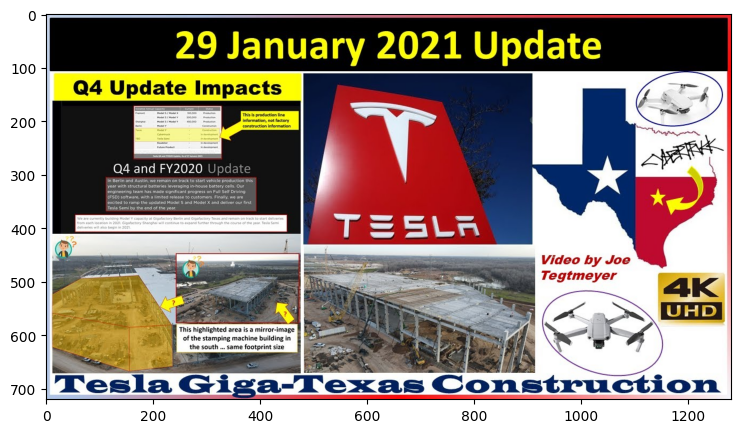

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

imageUrl = "./texas.jpg"
image = Image.open(imageUrl).convert("RGB")

plt.figure(figsize=(16, 5))
plt.imshow(image)

### Running LLaVa model using Replicate through LlamaIndex for image understanding

In [ ]:
from llama_index.multi_modal_llms.replicate import ReplicateMultiModal
from llama_index.core.schema import ImageDocument
from llama_index.multi_modal_llms.replicate.base import (
    REPLICATE_MULTI_MODAL_LLM_MODELS,
)

print(imageUrl)

llava_multi_modal_llm = ReplicateMultiModal(
    model=REPLICATE_MULTI_MODAL_LLM_MODELS["llava-13b"],
    max_new_tokens=200,
    temperature=0.1,
)

prompt = "which Tesla factory is shown in the image? Please answer just the name of the factory."

llava_response = llava_multi_modal_llm.complete(
    prompt=prompt,
    image_documents=[ImageDocument(image_path=imageUrl)],
)

./texas.jpg


In [ ]:
print(llava_response.text)

Gigafactory


### Retrieve relevant information from LlamaIndex knowledge base based on LLaVa image understanding to augment `Image Captioning`

In [ ]:
rag_response = query_engine.query(llava_response.text)

In [ ]:
print(rag_response)

Gigafactory is a term used by Tesla to describe its expansive manufacturing facilities that are strategically located in various regions worldwide. These factories are specifically designed to produce a range of Tesla products, including electric vehicles, battery cells, and energy storage solutions. Currently, Tesla operates Gigafactories in Nevada, New York, Shanghai, and Berlin, with plans to establish another one in Texas. The primary objective of these Gigafactories is to significantly enhance Tesla's production capabilities, drive down costs, and optimize operational efficiency across its manufacturing operations.


## Multi-Modal Pydantic Program with LLaVa

### Initialize the Instagram Ads Pydantic Class

In [ ]:
input_image_path = Path("instagram_images")
if not input_image_path.exists():
    Path.mkdir(input_image_path)

In [ ]:
!wget "https://docs.google.com/uc?export=download&id=12ZpBBFkYu-jzz1iz356U5kMikn4uN9ww" -O ./instagram_images/jordan.png

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/loganm/.wget-hsts'. HSTS will be disabled.
--2024-01-15 14:39:59--  https://docs.google.com/uc?export=download&id=12ZpBBFkYu-jzz1iz356U5kMikn4uN9ww
Resolving docs.google.com (docs.google.com)... 142.251.32.78, 2607:f8b0:400b:807::200e
Connecting to docs.google.com (docs.google.com)|142.251.32.78|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=12ZpBBFkYu-jzz1iz356U5kMikn4uN9ww&export=download [following]
--2024-01-15 14:40:00--  https://drive.usercontent.google.com/download?id=12ZpBBFkYu-jzz1iz356U5kMikn4uN9ww&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.32.65, 2607:f8b0:400b:802::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.32.65|:443... connected.
HTTP request sent, awaiting response

In [ ]:
from pydantic import BaseModel


class InsAds(BaseModel):
    """Data model for a Ins Ads."""

    account: str
    brand: str
    product: str
    category: str
    discount: str
    price: str
    comments: str
    review: str
    description: str

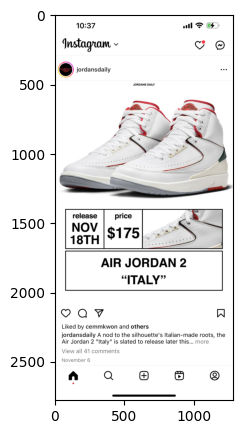

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

ins_imageUrl = "./instagram_images/jordan.png"
image = Image.open(ins_imageUrl).convert("RGB")

plt.figure(figsize=(16, 5))
plt.imshow(image)

### Using Multi-Modal Pydantic Program to generate structured output using Llava-13b

In [ ]:
from llama_index.multi_modal_llms.replicate import ReplicateMultiModal
from llama_index.core.program import MultiModalLLMCompletionProgram
from llama_index.core.output_parsers import PydanticOutputParser
from llama_index.multi_modal_llms.replicate.base import (
    REPLICATE_MULTI_MODAL_LLM_MODELS,
)

prompt_template_str = """\
    can you summarize what is in the image\
    and return the answer with json format \
"""


def pydantic_llava(
    model_name, output_class, image_documents, prompt_template_str
):
    mm_llm = ReplicateMultiModal(
        model=REPLICATE_MULTI_MODAL_LLM_MODELS["llava-13b"],
        max_new_tokens=1000,
    )

    llm_program = MultiModalLLMCompletionProgram.from_defaults(
        output_parser=PydanticOutputParser(output_class),
        image_documents=image_documents,
        prompt_template_str=prompt_template_str,
        multi_modal_llm=mm_llm,
        verbose=True,
    )

    response = llm_program()
    print(f"Model: {model_name}")
    for res in response:
        print(res)
    return response

### Output Structured Pydantic Output

In [ ]:
from llama_index.core import SimpleDirectoryReader

ins_image_documents = SimpleDirectoryReader("./instagram_images").load_data()

pydantic_response = pydantic_llava(
    "llava-13b", InsAds, ins_image_documents, prompt_template_str
)

Model: llava-13b
('account', 'airjordan')
('brand', 'Air Jordan')
('product', 'Air Jordan 2')
('category', 'Sneakers')
('discount', '15%')
('price', '$175')
('comments', '')
('review', '')
('description', 'Italy.')


In [ ]:
print(pydantic_response.brand)

Air Jordan


## Advanced Multi-Modal Retrieval using GPT4V and Multi-Modal Index/Retriever/Query Engine

### Downloading text, images data from raw files [Wikipedia] for Multi Modal Index/Retrieval

In [ ]:
from pathlib import Path
import requests

wiki_titles = [
    "batman",
    "Vincent van Gogh",
    "San Francisco",
    "iPhone",
    "Tesla Model S",
    "BTS",
    "Air Jordan",
]


data_path = Path("data_wiki")


for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    if not data_path.exists():
        Path.mkdir(data_path)

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

In [ ]:
import wikipedia
import urllib.request

image_path = Path("data_wiki")
image_uuid = 0
# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 30

wiki_titles = [
    "Air Jordan",
    "San Francisco",
    "Batman",
    "Vincent van Gogh",
    "iPhone",
    "Tesla Model S",
    "BTS band",
]

# create folder for images only
if not image_path.exists():
    Path.mkdir(image_path)

# Download images for wiki pages
# Assing UUID for each image
for title in wiki_titles:
    images_per_wiki = 0
    print(title)
    try:
        page_py = wikipedia.page(title)
        list_img_urls = page_py.images
        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1
                image_file_name = title + "_" + url.split("/")[-1]

                # img_path could be s3 path pointing to the raw image file in the future
                image_metadata_dict[image_uuid] = {
                    "filename": image_file_name,
                    "img_path": "./" + str(image_path / f"{image_uuid}.jpg"),
                }
                urllib.request.urlretrieve(
                    url, image_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        print(str(Exception("No images found for Wikipedia page: ")) + title)
        continue

### Build Multi-modal index and Vector Store to index both text and images

In [ ]:
import qdrant_client
from llama_index.core import SimpleDirectoryReader
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.core.indices import MultiModalVectorStoreIndex

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_mm_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
documents = SimpleDirectoryReader("./data_wiki/").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

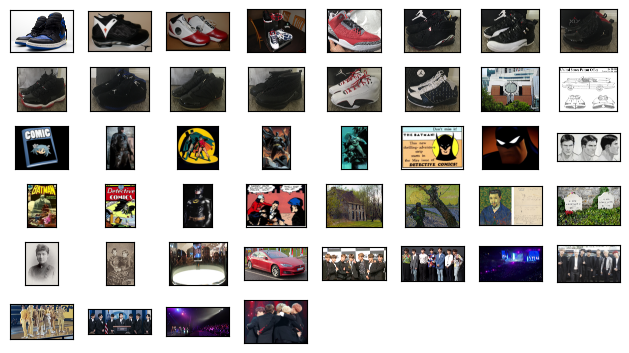

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os


def plot_images(image_metadata_dict):
    original_images_urls = []
    images_shown = 0
    for image_id in image_metadata_dict:
        img_path = image_metadata_dict[image_id]["img_path"]
        if os.path.isfile(img_path):
            filename = image_metadata_dict[image_id]["filename"]
            image = Image.open(img_path).convert("RGB")

            plt.subplot(8, 8, len(original_images_urls) + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            original_images_urls.append(filename)
            images_shown += 1
            if images_shown >= 64:
                break

    plt.tight_layout()


plot_images(image_metadata_dict)

### Multi-Modal RAG Retrieval and Querying using LlaVa pydantic structured output

In [ ]:
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(pydantic_response.brand)

**Node ID:** 88152a5f-b72d-4b97-915d-f4d27a233bc2<br>**Similarity:** 0.8671320192132904<br>**Text:** Air Jordan is a line of basketball shoes produced by Nike, Inc. Related apparel and accessories are marketed under Jordan Brand.
The first Air Jordan shoe was produced for basketball player Michael...<br>

**Node ID:** b11f9bd5-ad86-4a53-8622-85418e6bb70b<br>**Similarity:** 0.8659507837211329<br>**Text:** === Jordan "6 Rings" shoe ===
The Jordan 6 Rings (aka Jordan Six Rings, Or Montells) is a combination of the seven Air Jordan shoes that Michael Jordan wore during his 6 championship seasons. That ...<br>

**Node ID:** 0d7d5283-d4d9-476b-a4cd-81d9949cc60b<br>**Similarity:** 0.8545030450835027<br>**Text:** === Sneaker collecting ===

The shoes have had a large impact on the rise of "sneakerhead" culture. In the 1980s, collecting sneakers became more common, as well as trading and reselling them. As n...<br>

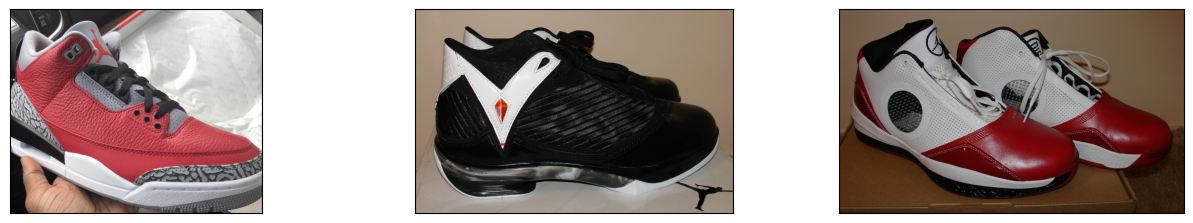

In [ ]:
from llama_index.core.response.notebook_utils import (
    display_source_node,
    display_image_uris,
)
from llama_index.core.schema import ImageNode

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)


display_image_uris(retrieved_image)

### Synthesis the RAG results using retrieved texts and images

In [ ]:
from llama_index.core import PromptTemplate
from llama_index.core.query_engine import SimpleMultiModalQueryEngine

qa_tmpl_str = (
    "Context information is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)
qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    multi_modal_llm=llava_multi_modal_llm,
    text_qa_template=qa_tmpl,
    similarity_top_k=2,
    image_similarity_top_k=1,
)

query_str = "Tell me more about the " + pydantic_response.brand + " brand."
response = query_engine.query(query_str)

In [ ]:
print(response)

The Air Jordan brand is a line of basketball shoes produced by Nike, Inc. It was created for Michael Jordan, a basketball player who played for the Chicago Bulls during the 1980s and 1990s. The first Air Jordan shoe was released in 1985, and it has since become one of the most iconic and successful shoe lines in history. The shoes are known for their distinctive design, high-quality materials, and innovative technology, which has helped to establish the Air Jordan brand as a leader in the athletic footwear industry. The brand has also expanded to include apparel, accessories, and other products, and has become a cultural phenomenon, with a significant impact on fashion, music, and popular culture.
